## **Functions and Classes**

### **Packages and Utilities**

#### **Import Some Packages**

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchmetrics import R2Score

# Data process
import numpy as np
import pandas as pd
import math
import csv
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold


# Plot figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#### **Reproducibility**

In [2]:
myseed = 870529  # Set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

#### **5-Fold Sampler index**

In [3]:
def KfoldSampler(datalen, sngdatalen, init_idx, seed):
    data_idx = np.arange(datalen)
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    stored_idx = {'fold1_tr':'', 'fold1_vd':'', 'fold2_tr':'', 'fold2_vd':'',
    'fold3_tr':'', 'fold3_vd':'', 'fold4_tr':'', 'fold4_vd':'','fold5_tr':'', 'fold5_vd':''}

    for fold, [tr_idx, vd_idx] in enumerate(kf.split(data_idx)) :
        tr_cv = np.array([], dtype=int)
        vd_cv = np.array([], dtype=int)
        for tr_a in tr_idx :
            temp = np.arange(tr_a*sngdatalen+init_idx, (tr_a+1)*sngdatalen+init_idx)
            tr_cv = np.append(tr_cv, temp)
        np.random.shuffle(tr_cv)
        stored_idx['fold{:d}_tr'.format(fold+1)]=tr_cv


        for vd_a in vd_idx :
            temp = np.arange(vd_a*sngdatalen+init_idx, (vd_a+1)*sngdatalen+init_idx)
            vd_cv = np.append(vd_cv, temp)
        
        stored_idx['fold{:d}_vd'.format(fold+1)]=vd_cv

    return stored_idx
    

In [4]:
#For 300,000 data
lowspeed_idx = KfoldSampler(10, 10000, 0, myseed)
midspeed_idx = KfoldSampler(20, 5000, 100000, myseed)
highspeed_idx = KfoldSampler(40, 2500, 200000, myseed)

# # For 150,000 data
# lowspeed_idx = KfoldSampler(5, 10000, 0, myseed)
# midspeed_idx = KfoldSampler(10, 5000, 50000, myseed)
# highspeed_idx = KfoldSampler(20, 2500, 100000, myseed)

# For 60,000 data
# lowspeed_idx = KfoldSampler(2, 10000, 0, myseed)
# midspeed_idx = KfoldSampler(4, 5000, 40000, myseed)
# highspeed_idx = KfoldSampler(8, 2500, 80000, myseed)

# Get keys from one of the dictionary
ks = [k for k in lowspeed_idx.keys()]

kfold_idx = {k: np.stack([lowspeed_idx[k], midspeed_idx[k], highspeed_idx[k]], axis=0).flatten() for k in ks}

print(len(kfold_idx['fold1_vd']))



60000


#### **Switch to GPU if available**

In [5]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

### **Dataset**

We have two kinds of datasets:
* `train`: for training and validation
* `test`: for testing 

The `TrajDataset` below does:
* read `.xlsx` files
* extract features
* normalize features


In [6]:
class TrajDataset(Dataset):
    def __init__(self, path, mode='test'):

        # Read data to dataframe
        df = pd.read_excel(path)

        # Split data to feature and target & Transfer to numpy 
        feature_np = df.iloc[:, 1:10].to_numpy()
        target_np = df.iloc[:, 10:13].to_numpy()
        
        # Transfer data to tensor
        self.feature = torch.Tensor(feature_np)
        self.target = torch.Tensor(target_np)

        # Transfer feature data to (0,1) -> MinMaxScalar
        self.feature[:, 1:4] = (self.feature[:, 1:4] + 150) / 300
        self.feature[:, 4:7] = (self.feature[:, 4:7] + 830) / 1660      
        self.feature[:, 7:10] = (self.feature[:, 7:10] + 980) / 1960

        # Get sample number of data
        self.dim = self.feature.shape[1]

        print('Finished reading the Trajectory Dataset ({} samples found, each dim = {})'
              .format(len(self.feature), self.dim))

    def __getitem__(self, index) :

        return self.feature[index], self.target[index]

    def __len__(self) :

        return len(self.feature)

### **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for neural network.
The DNN consists of 7 fully-connected layers with Softplus activation.
This module also included a function `cal_loss` for calculating loss.

In [8]:
class DDNN(nn.Module) : 
    def __init__(self, layers):
        super(DDNN, self).__init__()

        input_dim = 9
        output_dim = 3

        h1, h2, h3 = layers[1], layers[2], layers[3]
        h4, h5  = layers[4], layers[5]

        # Layer Strucutre
        self.l1 = nn.Linear(input_dim, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, h5)
        self.l6 = nn.Linear(h5, output_dim)


        # Define Activation Function 
        # Use Softplus for smoother result (compared with ReLU)
        self.act1 = nn.Softplus()
        self.act2 = nn.Softplus()
        self.act3 = nn.Softplus()
        self.act4 = nn.Softplus()
        self.act5 = nn.Softplus()
       

    def forward(self, x):
        
        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        x = self.act3(x)
        x = self.l4(x)
        x = self.act4(x)
        x = self.l5(x)
        x = self.act5(x)
        x = self.l6(x)

        return x
    


#### **Get hidden layer value**

In [9]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

#### **Inverse Dynamics**

In [11]:
def InvDyn(tk_space):

    samples = tk_space.shape[0]    
    # Parameters
    unit = 1000
    L_init = (518.067753315)/unit
    D = (450 - 160)/unit
    Norm_Z = 429.295/unit

    # Task space data
    x_raw, y_raw, z_raw = tk_space[:, 0], tk_space[:, 1], tk_space[: , 2]
    x_d_raw, y_d_raw, z_d_raw = tk_space[:, 3], tk_space[:, 4], tk_space[: , 5]
    x_dd_raw, y_dd_raw, z_dd_raw = tk_space[:, 6], tk_space[:, 7], tk_space[:, 8]


    x, y, z = (300*x_raw-150)/unit, (300*y_raw-150)/unit, (300*z_raw-150)/unit
    x_d, y_d, z_d = (1660*x_d_raw-830)/unit, (1660*y_d_raw-830)/unit, (1660*z_d_raw-830)/unit
    x_dd, y_dd, z_dd = (1960 * x_dd_raw - 980)/unit, (1960 * y_dd_raw - 980)/unit, (1960 * z_dd_raw - 980)/unit


    L1 = torch.sqrt( x**2 + (y-D)**2 + (z-Norm_Z)**2 ) 
    L2 = torch.sqrt( (x + math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
    L3 = torch.sqrt( (x - math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
    
    L1_d = x / L1 * x_d + ( y - D ) / L1 * y_d + ( z - Norm_Z ) / L1 * z_d  
    L2_d = (x + math.sqrt(3) * D / 2 ) / L2 * x_d + ( y + D / 2 ) / L2 * y_d + ( z - Norm_Z ) / L2 * z_d
    L3_d = (x - math.sqrt(3) * D / 2 ) / L3 * x_d + ( y + D / 2 ) / L3 * y_d + ( z - Norm_Z ) / L3 * z_d 

    L1_dd =  x / L1 * (x_dd - x_d * L1_d/L1) + x_d**2 / L1 + \
        ( y - D ) * (y_dd - y_d * L1_d / L1) + y_d**2 / L1 + \
        ( z - Norm_Z ) * (z_dd - z_d * L1_d / L1) + z_d**2 / L1 
    L2_dd = (x + math.sqrt(3) * D / 2 ) / L2 * (x_dd - x_d * L2_d / L2) + x_d**2 / L2 + \
        (y + D / 2) / L2 * (y_dd - y_d * L2_d / L2) + y_d**2 / L2 + \
        ( z - Norm_Z ) / L2 * (z_dd - z_d * L2_d / L2) + z_d**2 / L2
    L3_dd = (x - math.sqrt(3) * D / 2 ) / L3 * (x_dd - x_d * L3_d / L3) + x_d**2 / L3 + \
        (y + D / 2) / L3 * (y_dd - y_d * L3_d / L3) + y_d**2 / L3 + \
        ( z - Norm_Z ) / L3 * (z_dd - z_d * L3_d / L3) + z_d**2 / L3

    L1, L2, L3 =  torch.reshape(L1, (samples, -1)), torch.reshape(L2, (samples, -1)), torch.reshape(L3, (samples, -1))  
    L1_d, L2_d, L3_d =  torch.reshape(L1_d, (samples, -1)), torch.reshape(L2_d, (samples, -1)), torch.reshape(L3_d, (samples, -1))
    L1_dd, L2_dd, L3_dd =  torch.reshape(L1_dd, (samples, -1)), torch.reshape(L2_dd, (samples, -1)), torch.reshape(L3_dd, (samples, -1)) 
            
    jt_space = torch.cat((L1, L2, L3, L1_d, L2_d, L3_d, L1_dd, L2_dd, L3_dd),1)
    
    return jt_space

#### **Custom Loss**

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, mode='mse'):
        super(CustomLoss, self).__init__()
        self.mode = mode

    def forward(self, output, target, tk_space, jt_space):

        if self.mode == 'phys1':

            jt_target = InvDyn(tk_space) 

            # print('jt_target : ')
            # print(jt_target)

            mse_loss = torch.mean((output-target)**2)

            pen_loss = torch.mean((jt_space-jt_target)**2)

            penalty = 10**(2)

            total_loss = mse_loss + penalty * pen_loss

            return total_loss, mse_loss, pen_loss

        elif self.mode == 'phys2':
            
            jt_target = InvDyn(tk_space) 

            mse_loss = torch.mean((output-target)**2)

            # pos_pred, vel_pred, accel_pred = torch.split(jt_space, 3, dim = 1)



            # pos_target, vel_target, accel_target = torch.split(jt_space, 3, dim = 1)

            # pos_loss = torch.mean((pos_pred-pos_target)**2)
            # vel_loss = torch.mean((vel_pred-vel_target)**2)
            # accel_loss = torch.mean((accel_pred-accel_target)**2)

            # penalty = 5*10**(1)

            # pen_loss = penalty * ( pos_loss + vel_loss + accel_loss )

            pen_loss = torch.mean((jt_space-jt_target)**2)

            penalty = 100

            pen_loss_total =  penalty * pen_loss

            total_loss = mse_loss + pen_loss_total


            return total_loss, mse_loss, pen_loss


        elif self.mode == 'phys3':

            # Parameters
            L_init = 518.067753315/1000
            D = (450 - 160)/1000
            Norm_Z = 429.295/1000
            # Task space data
            x_raw, y_raw, z_raw = tk_space[:, 0], tk_space[:, 1], tk_space[: , 2]
            x_d_raw, y_d_raw, z_d_raw = tk_space[:, 3], tk_space[:, 4], tk_space[: , 5]
            x_dd_raw, y_dd_raw, z_dd_raw = tk_space[:, 6], tk_space[:, 7], tk_space[:, 8]

            L1_pred, L2_pred, L3_pred = jt_space[:, 0], jt_space[:, 1], jt_space[: , 2]
            L1_d_pred, L2_d_pred, L3_d_pred = jt_space[:, 3], jt_space[:, 4], jt_space[: , 5]
            L1_dd_pred, L2_dd_pred, L3_dd_pred = jt_space[:, 6], jt_space[:, 7], jt_space[:, 8]

            x, y, z = (300*x_raw-150)/100, (300*y_raw-150)/100, (300*z_raw-150)/100
            x_d, y_d, z_d = (1660*x_d_raw-830)/100, (1660*y_d_raw-830)/100, (1660*z_d_raw-830)/100
            x_dd, y_dd, z_dd = (1960 * x_dd_raw - 980)/100, (1960 * y_dd_raw - 980)/100, (1960 * z_dd_raw - 980)/100

            L1_target = torch.sqrt( x**2 + (y-D)**2 + (z-Norm_Z)**2 ) 
            L2_target = torch.sqrt( (x + math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
            L3_target = torch.sqrt( (x - math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
            
            L1_d_target = x / L1_target * x_d + ( y - D ) / L1_target * y_d + ( z - Norm_Z ) / L1_target * z_d  
            L2_d_target = (x + math.sqrt(3) * D / 2 ) / L2_target * x_d + ( y + D / 2 ) / L2_target * y_d + ( z - Norm_Z ) / L2_target * z_d
            L3_d_target = (x - math.sqrt(3) * D / 2 ) / L3_target * x_d + ( y + D / 2 ) / L3_target * y_d + ( z - Norm_Z ) / L3_target * z_d 

            L1_dd_target =  x / L1_target * (x_dd - x_d * L1_d_target/L1_target) + x_d**2 / L1_target + \
                ( y - D ) * (y_dd - y_d * L1_d_target / L1_target) + y_d**2 / L1_target + \
                ( z - Norm_Z ) * (z_dd - z_d * L1_d_target / L1_target) + z_d**2 / L1_target
            L2_dd_target = (x + math.sqrt(3) * D / 2 ) / L2_target * (x_dd - x_d * L2_d_target / L2_target) + x_d**2 / L2_target + \
                (y + D / 2) / L2_target * (y_dd - y_d * L2_d_target / L2_target) + y_d**2 / L2_target + \
                ( z - Norm_Z ) / L2_target * (z_dd - z_d * L2_d_target / L2_target) + z_d**2 / L2_target
            L3_dd_target = (x - math.sqrt(3) * D / 2 ) / L3_target * (x_dd - x_d * L3_d_target / L3_target) + x_d**2 / L3_target + \
                (y + D / 2) / L3_target * (y_dd - y_d * L3_d_target / L3_target) + y_d**2 / L3_target + \
                ( z - Norm_Z ) / L3_target * (z_dd - z_d * L3_d_target / L3_target) + z_d**2 / L3_target

            # print(L1_target.shape[0], L1_target.shape[1])

            # L1_target, L2_target, L3_target =  torch.reshape(L1_target, (samples, -1)), torch.reshape(L2_target, (samples, -1)), torch.reshape(L3_target, (samples, -1))  
            # L1_d_target, L2_d_target, L3_d_target =  torch.reshape(L1_d_target, (samples, -1)), torch.reshape(L2_d_target, (samples, -1)), torch.reshape(L3_d_target, (samples, -1))
            # L1_dd_target, L2_dd_target, L3_dd_target =  torch.reshape(L1_dd_target, (samples, -1)), torch.reshape(L2_dd_target, (samples, -1)), torch.reshape(L3_dd_target, (samples, -1)) 

            pos_target, pos_pred = torch.stack((L1_target, L2_target, L3_target), -1), torch.stack((L1_pred, L2_pred, L3_pred), -1)
            vel_target, vel_pred = torch.stack((L1_d_target, L2_d_target, L3_d_target), -1), torch.stack((L1_d_pred, L2_d_pred, L3_d_pred), -1) 
            acc_target, acc_pred = torch.stack((L1_dd_target, L2_dd_target, L3_dd_target), -1), torch.stack((L1_dd_pred, L2_dd_pred, L3_dd_pred), -1) 

            mse_loss = torch.mean((output-target)**2)
            pos_loss = torch.mean((pos_pred-pos_target)**2)
            vel_loss = torch.mean((vel_pred-vel_target)**2)
            acc_loss = torch.mean((acc_pred-acc_target)**2)

            pos_pen = 1
            vel_pen = 1
            acc_pen = 1

            pen_loss = pos_loss + vel_loss + acc_loss

            total_loss = mse_loss + pos_pen * pos_loss + vel_pen * vel_loss + acc_pen * acc_loss

            return total_loss, mse_loss, pen_loss
        
        else :

            jt_target = InvDyn(tk_space) 

            mse_loss = torch.mean((output-target)**2)

            pen_loss = torch.mean((jt_space-jt_target)**2)

            penalty = 0

            total_loss = mse_loss + penalty * pen_loss

            return total_loss, mse_loss, pen_loss

       

### **Training/Validation**

#### **Training**

In [13]:
def train(tr_dataset, tr_idx, vd_idx, config, seed, device):

    n_epochs = config['n_epochs']

    loss_record = {'tr_loss': [], 'vd_loss': [], 'tr_mse':[], 'vd_mse':[], 'tr_pen':[],
     'tr_pen':[], 'vd_pen':[],'tr_acc': [], 'vd_acc': []}

    # R2 score object - ('uniform_average' for average, 'raw_value' for each target)             
    r2score = R2Score(num_outputs=3, multioutput='uniform_average').to(device, non_blocking=True) 

    # Initial model and optimizer in each fold
    model = DDNN(config['layers']).to(device)
    optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])
            
    criterion = CustomLoss(mode='phys2')

    hookF = [Hook(layer[1]) for layer in list(model._modules.items())]

    tr_sampler = SubsetRandomSampler(tr_idx)
    vd_sampler = SubsetRandomSampler(vd_idx)

    # Implement k-Fold index to dataset & Create dataloader 
    tr_loader = DataLoader(tr_dataset, config['batch_size'], shuffle = False, 
    drop_last=False, sampler=tr_sampler, num_workers=0, pin_memory=True)

    vd_loader = DataLoader(tr_dataset, config['batch_size'], shuffle = False, 
    drop_last=False, sampler=vd_sampler, num_workers=0, pin_memory=True)

    # Minimum loss - 
    # Initial epoch number and early stop (avoid overfitting)
    min_loss = 1000000000.
    epoch = 0
    early_stop_cnt = 0

    while epoch < n_epochs :
        
        # Model Training
        model.train()                                   # Model train mode - weight, bias is modifidable

        for x, y in tr_loader:
            
            optimizer.zero_grad()                       # Zero all gradient calculated by optimizer
            
            # Stack x, y into device (either cpu or gpu) 
            x, y = x.to(device), y.to(device)           # The length of x, y are batch size
            pred = model(x)

            jtspace = hookF[2].output

            tr_loss, tr_mse, tr_pen = criterion(pred, y, x, jtspace)            # Calculate loss with each batch (Criterion within CLASS model)
            tr_loss.backward()                          # Backpropagation (calculate each neuron gradient in terms of weight and bias)
            optimizer.step()                            # Change each weight and bias with optimizer
            
            # Calculate training R2 score in each batch 
            idx = [0, 1, 2]
            tr_accuracy = r2score(pred[:, idx], y[:, idx])

            # Store training record in each batch
            loss_record['tr_loss'].append(tr_loss.detach().cpu().item())
            loss_record['tr_mse'].append(tr_mse.detach().cpu().item())
            loss_record['tr_pen'].append(tr_pen.detach().cpu().item())
            loss_record['tr_acc'].append(tr_accuracy.item())

        # Model validation
        vd_loss, vd_mse, vd_pen, vd_accuracy = valid(vd_loader, model, criterion, hookF, device, r2score)

        
        if vd_mse < min_loss :  
            
            min_loss = vd_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f}, mse_loss = {:.4f}, pen_loss = {:.4f}, acc = {:.4f})'
                    .format(epoch + 1, vd_loss, min_loss, vd_pen, vd_accuracy))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt +=1 
        epoch += 1

        loss_record['vd_loss'].append(vd_loss)
        loss_record['vd_mse'].append(vd_mse)
        loss_record['vd_pen'].append(vd_pen)
        loss_record['vd_acc'].append(vd_accuracy.item())
        
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break 

    print('Finished training after {} epochs'.format( epoch))

    return min_loss, loss_record 



#### **Validation**

In [14]:
def valid(vd_loader, model, criterion, hookF, device, r2score):

    model.eval()                        # Model evaluation mode - weight, bias is not modifidable
    
    total_loss = 0
    total_vd_mse = 0
    total_vd_pen = 0

    # Create torch to store prediction and target data
    temp_pred, temp_y = torch.ones(1, 3).to(device, non_blocking=True), torch.ones(1, 3).to(device, non_blocking=True)

    for x, y in vd_loader:

        # Stack x, y into device (either cpu or gpu) 
        x, y = x.to(device), y.to(device)                       # The length of x, y are batch size        
        
        # No gradient is update in this region
        with torch.no_grad():

            pred = model(x)
            jtspace = hookF[2].output

            # Store prediction and target data
            temp_pred = torch.cat((temp_pred, pred), 0)
            temp_y = torch.cat((temp_y, y), 0)
            vd_loss, vd_mse, vd_pen = criterion(pred, y, x, jtspace)             # Calculate loss with each batch (Criterion within CLASS model)
        
        # total loss - add all loss in each batch 
        # MSE  = error**2 / N
        total_vd_mse = total_vd_mse + vd_mse.detach().cpu().item() * len(x)
        total_vd_pen = total_vd_pen + vd_pen.detach().cpu().item() * len(x)
        total_loss = total_loss + vd_loss.detach().cpu().item() * len(x)    # ( *len(x) means error**2)            

    # total_loss/len to get the correct MSE in terms of a epoch
    total_loss = total_loss / len(vd_loader.dataset)            # Calculate validation loss with each epoch (Criterion within CLASS model)
    total_vd_mse = total_vd_mse / len(vd_loader.dataset)
    total_vd_pen = total_vd_pen / len(vd_loader.dataset)
    
    # Delete the initail value of tensor
    temp_pred = temp_pred[torch.arange(temp_pred.size(0)) != 0]
    temp_y = temp_y[torch.arange(temp_y.size(0)) != 0]

    # Calculate validation R2 score in each epoch
    idx = [0, 1, 2]
    vd_accuracy = r2score(temp_pred[:, idx], temp_y[:, idx])

    return total_loss, total_vd_mse, total_vd_pen, vd_accuracy

### **Hyper-parameters Setup**

`config` contains hyper-parameters for training and the path to save your model.

In [15]:
device = get_device()
os.makedirs('models', exist_ok=True) 

config = {
    'n_epochs': 15,                    # maximum number of epochs
    'batch_size': 16,                   # mini-batch size for dataloader
    'optimizer': 'Adam',                # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                   # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0005433177089293607                     # learning rate of Adam
    },
    'layers': np.array([9, 189, 119, 9, 53, 85, 3], dtype='int64'),    # layers of NN architecture
    'early_stop': 200,                  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pt'      # your model will be saved here
}

## **Code Execute from HERE~~**

### **Load Data**

In [16]:
tr_path = os.path.abspath("./Resources/TrainingData_PeriodicTraj.xlsx")

tr_dataset = TrajDataset(tr_path)

Finished reading the Trajectory Dataset (300000 samples found, each dim = 9)


### **Start Training**

In [17]:
model_loss_fold={'fold1':'', 'fold2':'', 'fold3':'', 'fold4':'', 'fold5':''}
avg_model_loss = 0

# Only runs fold 1
for fold in np.arange(1):
    print('Fold {:d}'.format(fold+1))
    tr_idx = kfold_idx['fold{}_tr'.format(fold+1)]
    vd_idx = kfold_idx['fold{}_vd'.format(fold+1)]
    model_loss, model_loss_record = train(tr_dataset, tr_idx, vd_idx, config, myseed, device)
    model_loss_fold['fold{}'.format(fold+1)] = model_loss_record
    avg_model_loss += model_loss

# avg_model_loss = avg_model_loss/5

# print(avg_model_loss)

Fold 1


KeyboardInterrupt: 

### **Save records**

In [ ]:
import pickle

os.makedirs('records', exist_ok=True) 

record_path = 'records/record.pkl'
f = open(record_path,'wb')
pickle.dump(model_loss_fold, f)
f.close()

### **Plot Learning Curve**

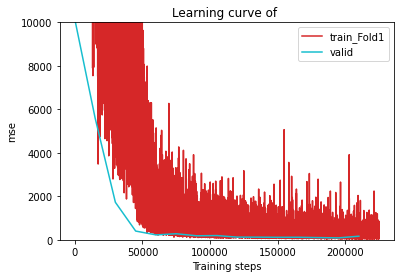

In [ ]:
def plot_learning_curve_kfold(loss_record, up_limit, type='loss', fold=1, title=''):
    ''' Plot learning curve of your DNN (train & valid loss) '''
    total_steps = len(loss_record['fold{}'.format(fold)]['tr_{}'.format(type)])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['fold{}'.format(fold)]['tr_{}'.format(type)]) // len(loss_record['fold{}'.format(fold)]['vd_{}'.format(type)])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['fold{}'.format(fold)]['tr_{}'.format(type)], c='tab:red', label='train_Fold{}'.format(fold))
    plt.plot(x_2, loss_record['fold{}'.format(fold)]['vd_{}'.format(type)], c='tab:cyan', label='valid')
    plt.ylim(0.0, up_limit)
    plt.xlabel('Training steps')
    plt.ylabel('{}'.format(type))
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['tr_loss'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['tr_loss']) // len(loss_record['vd_loss'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['tr_loss'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['vd_loss'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 10000.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    return x_1, x_2

plot_learning_curve_kfold(model_loss_fold, 10000., type='mse', fold=1)



Finished reading the Trajectory Dataset (10000 samples found, each dim = 9)
0.9975172063660235 0.9974314620661802 0.9991801691984902


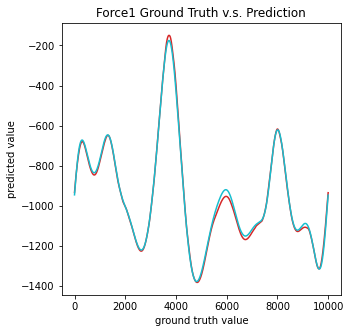

total_loss : 669.888428, mse : 150.321765, pen : 519.566650


In [ ]:
ts_path = os.path.abspath("./Resources/TestingData_PeriodicTraj_Single.xlsx")
ts_dataset = TrajDataset(ts_path)

test_config = {'save_path' : 'models/model.pt'}


model = DDNN(config['layers']).to(device)
ckpt = torch.load(test_config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
criterion = CustomLoss(mode='mse')


def test(ts_dataset, model, criterion, device, lim=35., preds=None, targets=None):
    ts_loader = DataLoader(ts_dataset, config['batch_size'], shuffle = False, 
    drop_last=False, num_workers=0, pin_memory=True)
    sample_num = len(ts_dataset)
    hookF = [Hook(layer[1]) for layer in list(model._modules.items())]

    if preds is None or targets is None:
        model.eval()
        preds, targets, jtlayers = [], [], []
        total_loss = 0
        total_ts_mse = 0
        total_ts_pen = 0
        cnt = 0
        for x, y in ts_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())

                jtlayer = hookF[2].output
                jtlayers.append(jtlayer.detach().cpu())
                ts_loss, ts_mse, ts_pen = criterion(pred, y, x, jtlayer)

            cnt = cnt+1
            total_loss = total_loss +  ts_mse.detach().cpu().item() * len(x) + ts_pen    # ( *len(x) means error**2)            
            total_ts_mse = total_ts_mse + ts_mse.detach().cpu().item() * len(x)
            total_ts_pen = total_ts_pen + ts_pen

        total_loss = total_loss / len(ts_loader.dataset)            # Calculate validation loss with each epoch (Criterion within CLASS model)
        total_ts_mse = total_ts_mse / len(ts_loader.dataset)
        total_ts_pen = total_ts_pen / len(ts_loader.dataset)
        preds = torch.cat(preds, 0).numpy().reshape((sample_num, 3))
        targets = torch.cat(targets, 0).numpy().reshape((sample_num, 3))
    return total_loss, total_ts_mse, total_ts_pen, preds, targets, jtlayers

# figure(figsize=(5, 5))
# total_steps = len(loss_record['train'])
# x_1 = range(total_steps)
# plt.scatter(targets, preds, c='r', alpha=0.5)
# plt.plot([-0.2, lim], [-0.2, lim], c='b')
# plt.xlim(-0.2, lim)
# plt.ylim(-0.2, lim)
# plt.xlabel('ground truth value')
# plt.ylabel('predicted value')
# plt.title('Ground Truth v.s. Prediction')
# plt.show()

from sklearn.metrics import r2_score


ts_loss, ts_mse, ts_pen, pred, target, jtlayers = test(ts_dataset, model, criterion, device)

ts_accuracy_1 = r2_score(pred[:, 0], target[:, 0])
ts_accuracy_2 = r2_score(pred[:, 1], target[:, 1])
ts_accuracy_3 = r2_score(pred[:, 2], target[:, 2])

print(ts_accuracy_1, ts_accuracy_2, ts_accuracy_3)



def plot_pred(pred, target, model, device, index=0):
    figure(figsize=(5, 5))
    total_steps = len(pred)
    x_1 = range(total_steps)
    plt.plot(x_1, pred[:, index], c='tab:red', label='prediction')
    plt.plot(x_1, target[:, index], c='tab:cyan', label='ground-truth')
    # plt.xlim(-0.2, lim)
    # plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Force{} Ground Truth v.s. Prediction'.format(index+1))
    plt.show()

plot_pred(pred, target, model, device, index=0)

print('total_loss : {:4f}, mse : {:4f}, pen : {:4f}'.format(ts_loss.item(), ts_mse, ts_pen.item()))






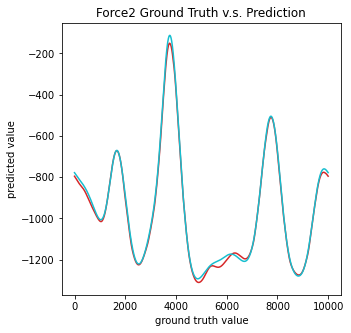

In [ ]:
plot_pred(pred, target, model, device, index=1)

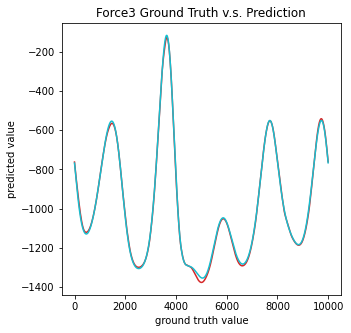

In [ ]:
plot_pred(pred, target, model, device, index=2)

### **Convert jupyter notebook file to python file**
Uncomment the script below to convert jupyter notebook file (.ipynb) to python file (.py)

In [2]:
# !jupyter nbconvert --to script ML_0801.ipynb 

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
